## Support Vector Machine (SVM), Decision Trees and Random Forests.
Based on accelerometer data from a mobile phone, it is necessary to classify what activity a person is performing: walking, standing, running, or climbing stairs. Use the SVM and Random Forest algorithms from the `scikit-learn` library. As features, you can use accelerometer readings; however, to improve the performance of the algorithms, you can first preprocess the dataset and calculate `time-domain features`. Compare the performance of both algorithms using different features and evaluate the models against each other. Use the classification report method for comparison.

In [1]:
import os
import pandas as pd
import numpy as np
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

In [2]:
# Unpacking the archive. Converting data from .csv files into a dictionary of datasets.

zip_file_path = './data.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

data_folder = 'data'

subdirectories = [subdir for subdir in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, subdir))]
print(subdirectories)
dataframes = {}

for subdir in subdirectories:
    subdir_path = os.path.join(data_folder, subdir)
    files = os.listdir(subdir_path)

    df = pd.DataFrame()

    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(subdir_path, file)
            data = pd.read_csv(file_path)
            df = pd.concat([df, data], ignore_index=True)

    dataframes[subdir] = df

for subdir, df in dataframes.items():
    print(f"Dataframe for {subdir}:")
    print(df.head(3))

['idle', 'running', 'stairs', 'walking']
Dataframe for idle:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0         1.000776         4.616021         8.576031
1         0.718261         4.209007         8.446744
2        -0.909797        -0.282516         9.203311
Dataframe for running:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0        -4.151545         1.781286         2.173935
1         2.020706         3.706224         9.921572
2         1.762132         4.242526         8.078037
Dataframe for stairs:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0         6.727707         2.973599         3.936068
1         7.891289         0.440533        -3.342306
2         6.301539        -1.154005         0.067038
Dataframe for walking:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0         2.322376         3.643975        11.827356
1         1.781286         4.668694         6.148310
2         7.963115        -4.113238         1.359907


In [3]:
# Adding a column to each dataset indicating the activity: 0 - 'idle', 1 - 'running', 2 - 'walking', 3 - 'stairs'. 
# Merging all datasets into a single DataFrame.

for index, (subdir, df) in enumerate(dataframes.items()):
    df['Action'] = index
    dataframes[subdir] = df

merged_df = pd.concat(dataframes.values(), ignore_index=True)
print(merged_df)

        accelerometer_X  accelerometer_Y  accelerometer_Z  Action
0              1.000776         4.616021         8.576031       0
1              0.718261         4.209007         8.446744       0
2             -0.909797        -0.282516         9.203311       0
3              5.099650         0.148441         8.418014       0
4              1.762132        -0.162806         9.251195       0
...                 ...              ...              ...     ...
193855         5.109226       -15.452178        -1.470040       3
193856         6.373365       -11.741165        -8.226476       3
193857         3.289633        -9.993398        -0.383072       3
193858        -2.978387        -3.050213         1.273715       3
193859        -4.347870        -9.926360        -1.642422       3

[193860 rows x 4 columns]


In [4]:
# Normalization using StandardScaler
scaler = StandardScaler()

# Normalize data except for the "Action" column
normalized_data = merged_df.drop(columns=['Action'])
normalized_data = scaler.fit_transform(normalized_data)

# Create a DataFrame with normalized data
normalized_df = pd.DataFrame(normalized_data, columns=merged_df.columns[:-1])  # excluding the "Action" column

# Add the "Action" column back from the original data
normalized_df['Action'] = merged_df['Action']

print(normalized_df)

        accelerometer_X  accelerometer_Y  accelerometer_Z  Action
0             -0.109791         0.241917         0.941538       0
1             -0.143404         0.209288         0.923560       0
2             -0.337109        -0.150782         1.028762       0
3              0.377889        -0.116234         0.919565       0
4             -0.019205        -0.141185         1.035420       0
...                 ...              ...              ...     ...
193855         0.379029        -1.366884        -0.455385       3
193856         0.529435        -1.069384        -1.394879       3
193857         0.162535        -0.929271        -0.304241       3
193858        -0.583227        -0.372659        -0.073862       3
193859        -0.746167        -0.923897        -0.479355       3

[193860 rows x 4 columns]


In [5]:
# Define a list of indices for the starting points of each segment.
# Split the data into segments and calculate time-domain features for each segment.
# Create a new DataFrame containing time-domain features for each segment along with the corresponding class labels.

# Step size for moving between segments (50% overlap)
segment_size = 208
step_size = int(segment_size / 2)

# Create a list of indices for the starting points of each segment
start_indexes = list(range(0, len(normalized_df), step_size))

In [6]:
# List to store time-domain features for each segment
time_domain_features = []

# Iterate over each starting index of the segments
for start_index in start_indexes:
    # Define the end of the current segment
    end_index = start_index + segment_size
    # Select data for the current segment
    segment_data = normalized_df.iloc[start_index:end_index, :-1]  # excluding the "Action" column

    # Calculate time-domain features for the current segment
    segment_features = {
        'mean_x': segment_data['accelerometer_X'].mean(),
        'mean_y': segment_data['accelerometer_Y'].mean(),
        'mean_z': segment_data['accelerometer_Z'].mean(),
        'std_x': segment_data['accelerometer_X'].std(),
        'std_y': segment_data['accelerometer_Y'].std(),
        'std_z': segment_data['accelerometer_Z'].std(),
        'min_x': segment_data['accelerometer_X'].min(),
        'min_y': segment_data['accelerometer_Y'].min(),
        'min_z': segment_data['accelerometer_Z'].min(),
        'max_x': segment_data['accelerometer_X'].max(),
        'max_y': segment_data['accelerometer_Y'].max(),
        'max_z': segment_data['accelerometer_Z'].max(),
        'median_x': segment_data['accelerometer_X'].median(),
        'median_y': segment_data['accelerometer_Y'].median(),
        'median_z': segment_data['accelerometer_Z'].median(),
        '25th_percentile_x': segment_data['accelerometer_X'].quantile(0.25),
        '25th_percentile_y': segment_data['accelerometer_Y'].quantile(0.25),
        '25th_percentile_z': segment_data['accelerometer_Z'].quantile(0.25),
        '75th_percentile_x': segment_data['accelerometer_X'].quantile(0.75),
        '75th_percentile_y': segment_data['accelerometer_Y'].quantile(0.75),
        '75th_percentile_z': segment_data['accelerometer_Z'].quantile(0.75),
        'rms_x': np.sqrt(np.mean(segment_data['accelerometer_X'] ** 2)),
        'rms_y': np.sqrt(np.mean(segment_data['accelerometer_Y'] ** 2)),
        'rms_z': np.sqrt(np.mean(segment_data['accelerometer_Z'] ** 2)),
        'mean': np.mean([segment_data['accelerometer_X'].mean(),
                         segment_data['accelerometer_Y'].mean(),
                         segment_data['accelerometer_Z'].mean()]),
        'std': np.mean([segment_data['accelerometer_X'].std(),
                        segment_data['accelerometer_Y'].std(),
                        segment_data['accelerometer_Z'].std()]),
        'min': np.mean([segment_data['accelerometer_X'].min(),
                        segment_data['accelerometer_Y'].min(),
                        segment_data['accelerometer_Z'].min()]),
        'max': np.mean([segment_data['accelerometer_X'].max(),
                        segment_data['accelerometer_Y'].max(),
                        segment_data['accelerometer_Z'].max()]),
        'median': np.mean([segment_data['accelerometer_X'].median(),
                           segment_data['accelerometer_Y'].median(),
                           segment_data['accelerometer_Z'].median()]),
        '25th_percentile': np.mean([segment_data['accelerometer_X'].quantile(0.25),
                                    segment_data['accelerometer_Y'].quantile(0.25),
                                    segment_data['accelerometer_Z'].quantile(0.25)]),
        '75th_percentile': np.mean([segment_data['accelerometer_X'].quantile(0.75),
                                    segment_data['accelerometer_Y'].quantile(0.75),
                                    segment_data['accelerometer_Z'].quantile(0.75)]),
        'rms': np.mean([np.sqrt(np.mean(segment_data['accelerometer_X'] ** 2)),
                        np.sqrt(np.mean(segment_data['accelerometer_Y'] ** 2)),
                        np.sqrt(np.mean(segment_data['accelerometer_Z'] ** 2))])
    }

    # Add time-domain features to the list
    time_domain_features.append(segment_features)

# Create a DataFrame with time-domain features
time_domain_df = pd.DataFrame(time_domain_features)

# Add the "Action" column from the list of indices
time_domain_df['Action'] = normalized_df['Action'].iloc[::step_size].values

print(time_domain_df.head())

     mean_x    mean_y    mean_z     std_x     std_y     std_z     min_x  \
0 -0.202181 -0.126462  1.103006  0.053560  0.036151  0.022645 -0.337109   
1 -0.181701 -0.130513  1.105669  0.006107  0.004067  0.003109 -0.196958   
2 -0.189516 -0.128106  1.106220  0.020195  0.007612  0.003319 -0.243675   
3 -0.190844 -0.127584  1.106399  0.021423  0.008076  0.003384 -0.244244   
4 -0.183419 -0.129795  1.106322  0.009757  0.004581  0.003245 -0.244244   

      min_y     min_z     max_x  ...     rms_z      mean       std       min  \
0 -0.150782  0.919565  0.377889  ...  1.103237  0.258121  0.037452  0.143891   
1 -0.144640  1.100672 -0.162205  ...  1.105674  0.264485  0.004427  0.253025   
2 -0.144640  1.100672 -0.162205  ...  1.106225  0.262866  0.010375  0.237452   
3 -0.144640  1.100672 -0.162205  ...  1.106404  0.262657  0.010961  0.237263   
4 -0.144640  1.100672 -0.162205  ...  1.106327  0.264370  0.005861  0.237263   

        max    median  25th_percentile  75th_percentile       rms  A

In [7]:
# Splitting the dataset into training and testing sets.

X = time_domain_df.drop(columns=['Action'])
y = time_domain_df['Action']

# Splitting the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training dataset size:', X_train.shape, y_train.shape)
print('Testing dataset size:', X_test.shape, y_test.shape)

Training dataset size: (1492, 32) (1492,)
Testing dataset size: (373, 32) (373,)


In [8]:
# Applying the Support Vector Machine method to train the model
svc_linear_clf = SVC(kernel='linear', C=1.0, random_state=42)
svc_linear_clf.fit(X_train, y_train)

# Prediction and model evaluation
y_predict_svc = svc_linear_clf.predict(X_test)

print(f"accuracy score on training sample = {accuracy_score(svc_linear_clf.predict(X_train), y_train)}")
print(f"accuracy score on test sample = {accuracy_score(svc_linear_clf.predict(X_test), y_test)}\n")

print(classification_report(y_test, y_predict_svc))

accuracy score on training sample = 0.9959785522788204
accuracy score on test sample = 0.9973190348525469

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      1.00      1.00       202
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00       101

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



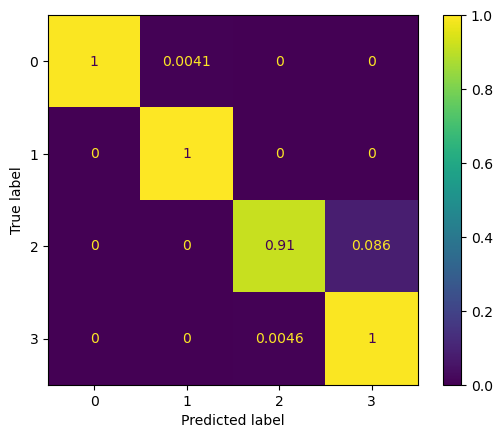

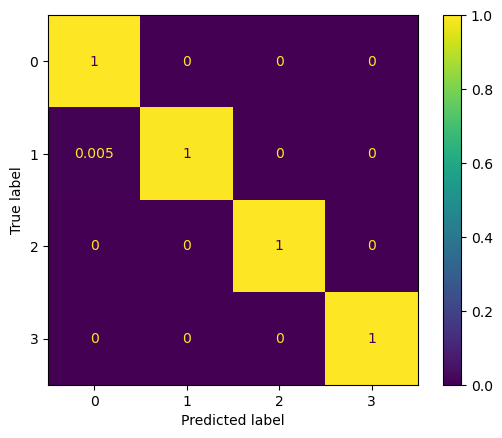

In [9]:
# Visualizing the evaluation of the method using the Confusion Matrix
matrix_train=ConfusionMatrixDisplay.from_estimator(svc_linear_clf, X_train, y_train, normalize='true')
matrix_test=ConfusionMatrixDisplay.from_estimator(svc_linear_clf, X_test, y_test, normalize='true')

In [10]:
# Applying the SVM method to train the model using the Radial Basis Function (RBF) kernel
svc_rbf_clf = SVC(kernel='rbf', random_state=42)
svc_rbf_clf.fit(X_train, y_train)

y_predict_svc_rbf = svc_rbf_clf.predict(X_test)

print(f"accuracy score on training sample = {accuracy_score(svc_rbf_clf.predict(X_train), y_train)}")
print(f"accuracy score on test sample = {accuracy_score(svc_rbf_clf.predict(X_test), y_test)}\n")

print(classification_report(y_test, y_predict_svc_rbf))

accuracy score on training sample = 0.9765415549597856
accuracy score on test sample = 0.967828418230563

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00       202
           2       1.00      0.08      0.14        13
           3       0.89      1.00      0.94       101

    accuracy                           0.97       373
   macro avg       0.97      0.77      0.77       373
weighted avg       0.97      0.97      0.95       373



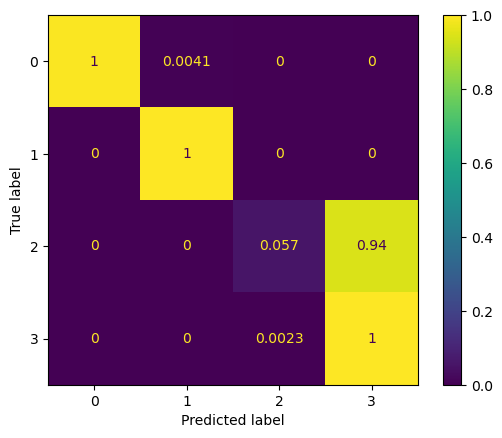

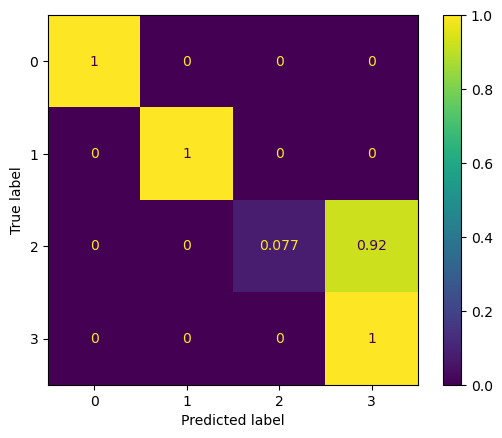

In [11]:
# Visualizing the evaluation of the method using the Confusion Matrix
matrix_train=ConfusionMatrixDisplay.from_estimator(svc_rbf_clf, X_train, y_train, normalize='true')
matrix_test=ConfusionMatrixDisplay.from_estimator(svc_rbf_clf, X_test, y_test, normalize='true')

In [12]:
# Training, prediction, and evaluation using the RandomForestClassifier decision tree method
rand_forrest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forrest_clf.fit(X_train, y_train)

y_predict_rand_forest = rand_forrest_clf.predict(X_test)

print(f"accuracy score on training sample = {accuracy_score(rand_forrest_clf.predict(X_train), y_train)}")
print(f"accuracy score on test sample = {accuracy_score(rand_forrest_clf.predict(X_test), y_test)}\n")

print(classification_report(y_test, y_predict_rand_forest))

accuracy score on training sample = 1.0
accuracy score on test sample = 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00       202
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00       101

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



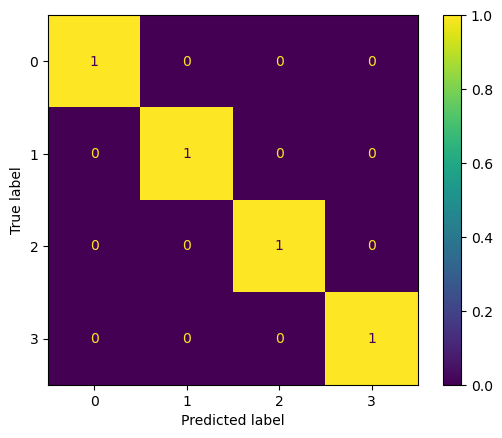

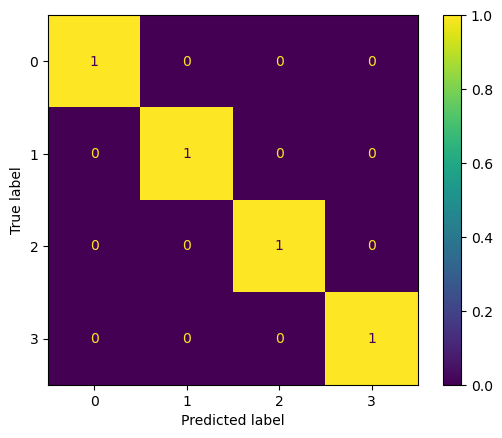

In [13]:
# Visualizing the evaluation of the method using the Confusion Matrix
matrix_train=ConfusionMatrixDisplay.from_estimator(rand_forrest_clf, X_train, y_train, normalize='true')
matrix_test=ConfusionMatrixDisplay.from_estimator(rand_forrest_clf, X_test, y_test, normalize='true')

### Conclusion Based on the Results of Three Models:

1. **Support Vector Machine (SVM) with Linear Kernel:**
   - **Accuracy**: 0.996 on the training set and 0.997 on the test set, which shows that the model performs extremely well on both training and test data.
   - **Precision, Recall, and F1-Score**: The model achieves almost perfect results across all classes, with F1-scores close to 1.0 for each class. This indicates that the SVM with a linear kernel performs well in distinguishing between the different activity classes (idle, running, walking, stairs).
   - **Conclusion**: This model is highly accurate, with strong performance across all metrics. It generalizes well to new data, making it a strong candidate for this classification task.

2. **Support Vector Machine (SVM) with Radial Basis Function (RBF) Kernel:**
   - **Accuracy**: 0.977 on the training set and 0.968 on the test set, which is lower than the linear kernel but still decent.
   - **Precision, Recall, and F1-Score**: Although the model has excellent precision and recall for classes 0 (idle) and 1 (running), it struggles significantly with class 2 (walking), with very low recall and F1-score. Class 3 (stairs) performs better but still has some challenges, showing a lower F1-score compared to the linear SVM.
   - **Conclusion**: The RBF kernel SVM has slightly reduced accuracy and struggles more with class imbalances. It might be less suitable for datasets with high variability in class frequencies or when one class is underrepresented, like class 2 in this case.

3. **Random Forest Classifier:**
   - **Accuracy**: 1.0 on both the training and test sets, indicating perfect performance on both sets.
   - **Precision, Recall, and F1-Score**: Like the linear SVM, Random Forest performs perfectly across all classes, with a precision, recall, and F1-score of 1.0 for each class.
   - **Conclusion**: The Random Forest classifier shows exceptional performance, with no misclassifications in the test set. This makes it the best performing model in terms of accuracy, precision, recall, and F1-score. Its perfect results suggest that it handles class imbalances and variability very well.

### Final Summary:
- **Best Performance**: The **Random Forest Classifier** outperforms the other models, achieving perfect accuracy, precision, recall, and F1-scores across all classes.
- **Linear SVM** follows closely behind with excellent results on both training and test data, and is a good alternative if Random Forest is not preferred due to model complexity or interpretability.
- **RBF Kernel SVM** offers decent performance but struggles with certain classes, especially when there is a significant class imbalance. It might need further tuning or resampling strategies to improve its handling of minority classes.